In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

#GPU 사용 설정, -1이면 CPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
fi = pd.read_csv('./data/df_all_best_type.csv')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# Load

In [70]:
pre_list = fi[fi['Type']=='PRE'].feature.to_list()
lab_list = fi[fi['Type']=='LAB'].feature.to_list()
pro_list = fi[fi['Type']=='PRO'].feature.to_list()

def what_type(x):
    if x in pre_list:
        return 'PRE'
    elif x in lab_list:
        return 'LAB'
    elif x in pro_list:
        return 'PRO'
    else:
        return 'ERROR'

In [132]:
near_result = pd.read_csv('./data/method2_nearscore.csv').sort_values('feature').reset_index(drop=True)
away_result = pd.read_csv('./data/method2_awayscore.csv').sort_values('feature').reset_index(drop=True)

In [133]:
near_result

,feature,score
0,0,-0.000000
1,50803,-0.000739
2,50804,0.003245
3,50805,-0.000276
4,50806,0.004817
...,...,...
4063,78112001103,-0.000263
4064,79511050204,-0.000000
4065,87701071218,0.009628
4066,87701083336,0.000000


In [134]:
near_std = np.std(near_result['score'])
near_mean = np.mean(near_result['score'])
near_min = min(near_result['score'])
near_max = max(near_result['score'])

away_std = np.std(away_result['score'])
away_mean = np.mean(away_result['score'])
away_min = min(away_result['score'])
away_max = max(away_result['score'])

In [135]:
near_result['normalized_score'] = near_result['score'].apply(lambda x:(x-near_min)/(near_max-near_min))
near_result['normalized_score1'] = near_result['score'].apply(lambda x:x/near_std)
near_result['normalized_score2'] = near_result['score'].apply(lambda x:(x-near_mean)/(near_std))

away_result['normalized_score'] = away_result['score'].apply(lambda x:(x-away_min)/(away_max-away_min))
away_result['normalized_score1'] = away_result['score'].apply(lambda x:x/away_std)
away_result['normalized_score2'] = away_result['score'].apply(lambda x:(x-away_mean)/(near_std))


In [139]:
away_result

,feature,score,normalized_score,normalized_score1,normalized_score2
0,0,-0.000000,0.833903,-0.000000,0.074850
1,50803,-0.000890,0.526331,-3.088741,-0.331933
2,50804,-0.000546,0.645283,-1.894180,-0.174611
3,50805,-0.000613,0.622308,-2.124905,-0.204997
4,50806,0.000000,0.833903,0.000000,0.074850
...,...,...,...,...,...
4063,78112001103,-0.000454,0.677070,-1.574969,-0.132571
4064,79511050204,-0.000011,0.830197,-0.037214,0.069949
4065,87701071218,0.000000,0.833903,0.000000,0.074850
4066,87701083336,0.000000,0.833903,0.000000,0.074850


In [136]:
final_df = near_result.feature.to_frame()
final_df['base'] = away_result['score'] - near_result['score']
final_df['score'] = away_result['normalized_score'] - near_result['normalized_score']
final_df['score1'] = away_result['normalized_score1'] - near_result['normalized_score1']
final_df['score2'] = away_result['normalized_score2'] - near_result['normalized_score2']
final_df['Type'] = final_result['feature'].apply(lambda x:what_type(int(x)))

In [137]:
final_df

,feature,base,score,score1,score2,Type
0,0,0.000000,0.623775,0.000000,0.406536,ERROR
1,50803,-0.000152,0.329269,-2.751334,0.337160,ERROR
2,50804,-0.003792,0.377744,-3.376734,-1.325479,ERROR
3,50805,-0.000337,0.417062,-1.998840,0.252754,ERROR
4,50806,-0.004817,0.538561,-2.200497,-1.793960,ERROR
...,...,...,...,...,...,...
4063,78112001103,-0.000191,0.471590,-1.454948,0.319135,ERROR
4064,79511050204,-0.000011,0.620070,-0.037214,0.401635,ERROR
4065,87701071218,-0.009628,0.453451,-4.398325,-3.991789,ERROR
4066,87701083336,0.000000,0.623775,0.000000,0.406536,ERROR


In [127]:
pd.read_csv(path + 'method2_df_scaled.csv').sort_values('feature')

,feature,scaled mul,diff_scale
741,0,-0.000000,0.000000
1616,50803,-0.337407,-0.069376
3821,50804,1.482554,-1.732015
2270,50805,-0.126065,-0.153783
3898,50806,2.200497,-2.200497
...,...,...,...
1757,78112001103,-0.120020,-0.087401
968,79511050204,-0.000000,-0.004901
4028,87701071218,4.398325,-4.398325
863,87701083336,0.000000,0.000000


# Visualization

In [89]:
### 사망/퇴원 환자 df 분리

X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    for i, f in enumerate(top10_list):
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
    plt.tight_layout()

## Score 기준 (Minmax Scale)

In [90]:
temp = final_df.copy()
temp = temp.sort_values('score', ascending=False)

In [91]:
temp

,feature,score,score1,score2,Type
217,51301,0.734205,1.108970,0.552586,PRE
3723,61553015311,0.731929,0.171726,-0.870066,PRO
933,54008826,0.721948,0.850938,0.326868,PRE
2945,49502069724,0.714070,0.906775,0.525958,PRE
2633,904516561,0.706947,0.835242,0.516537,PRE
...,...,...,...,...,...
162,51200,0.090440,-3.216326,3.023020,PRE
37,50889,0.089842,-2.983559,3.392937,PRE
2312,517293025,0.037084,-4.897590,1.174088,LAB
383,227194,0.000000,-2.948159,4.729822,PRO


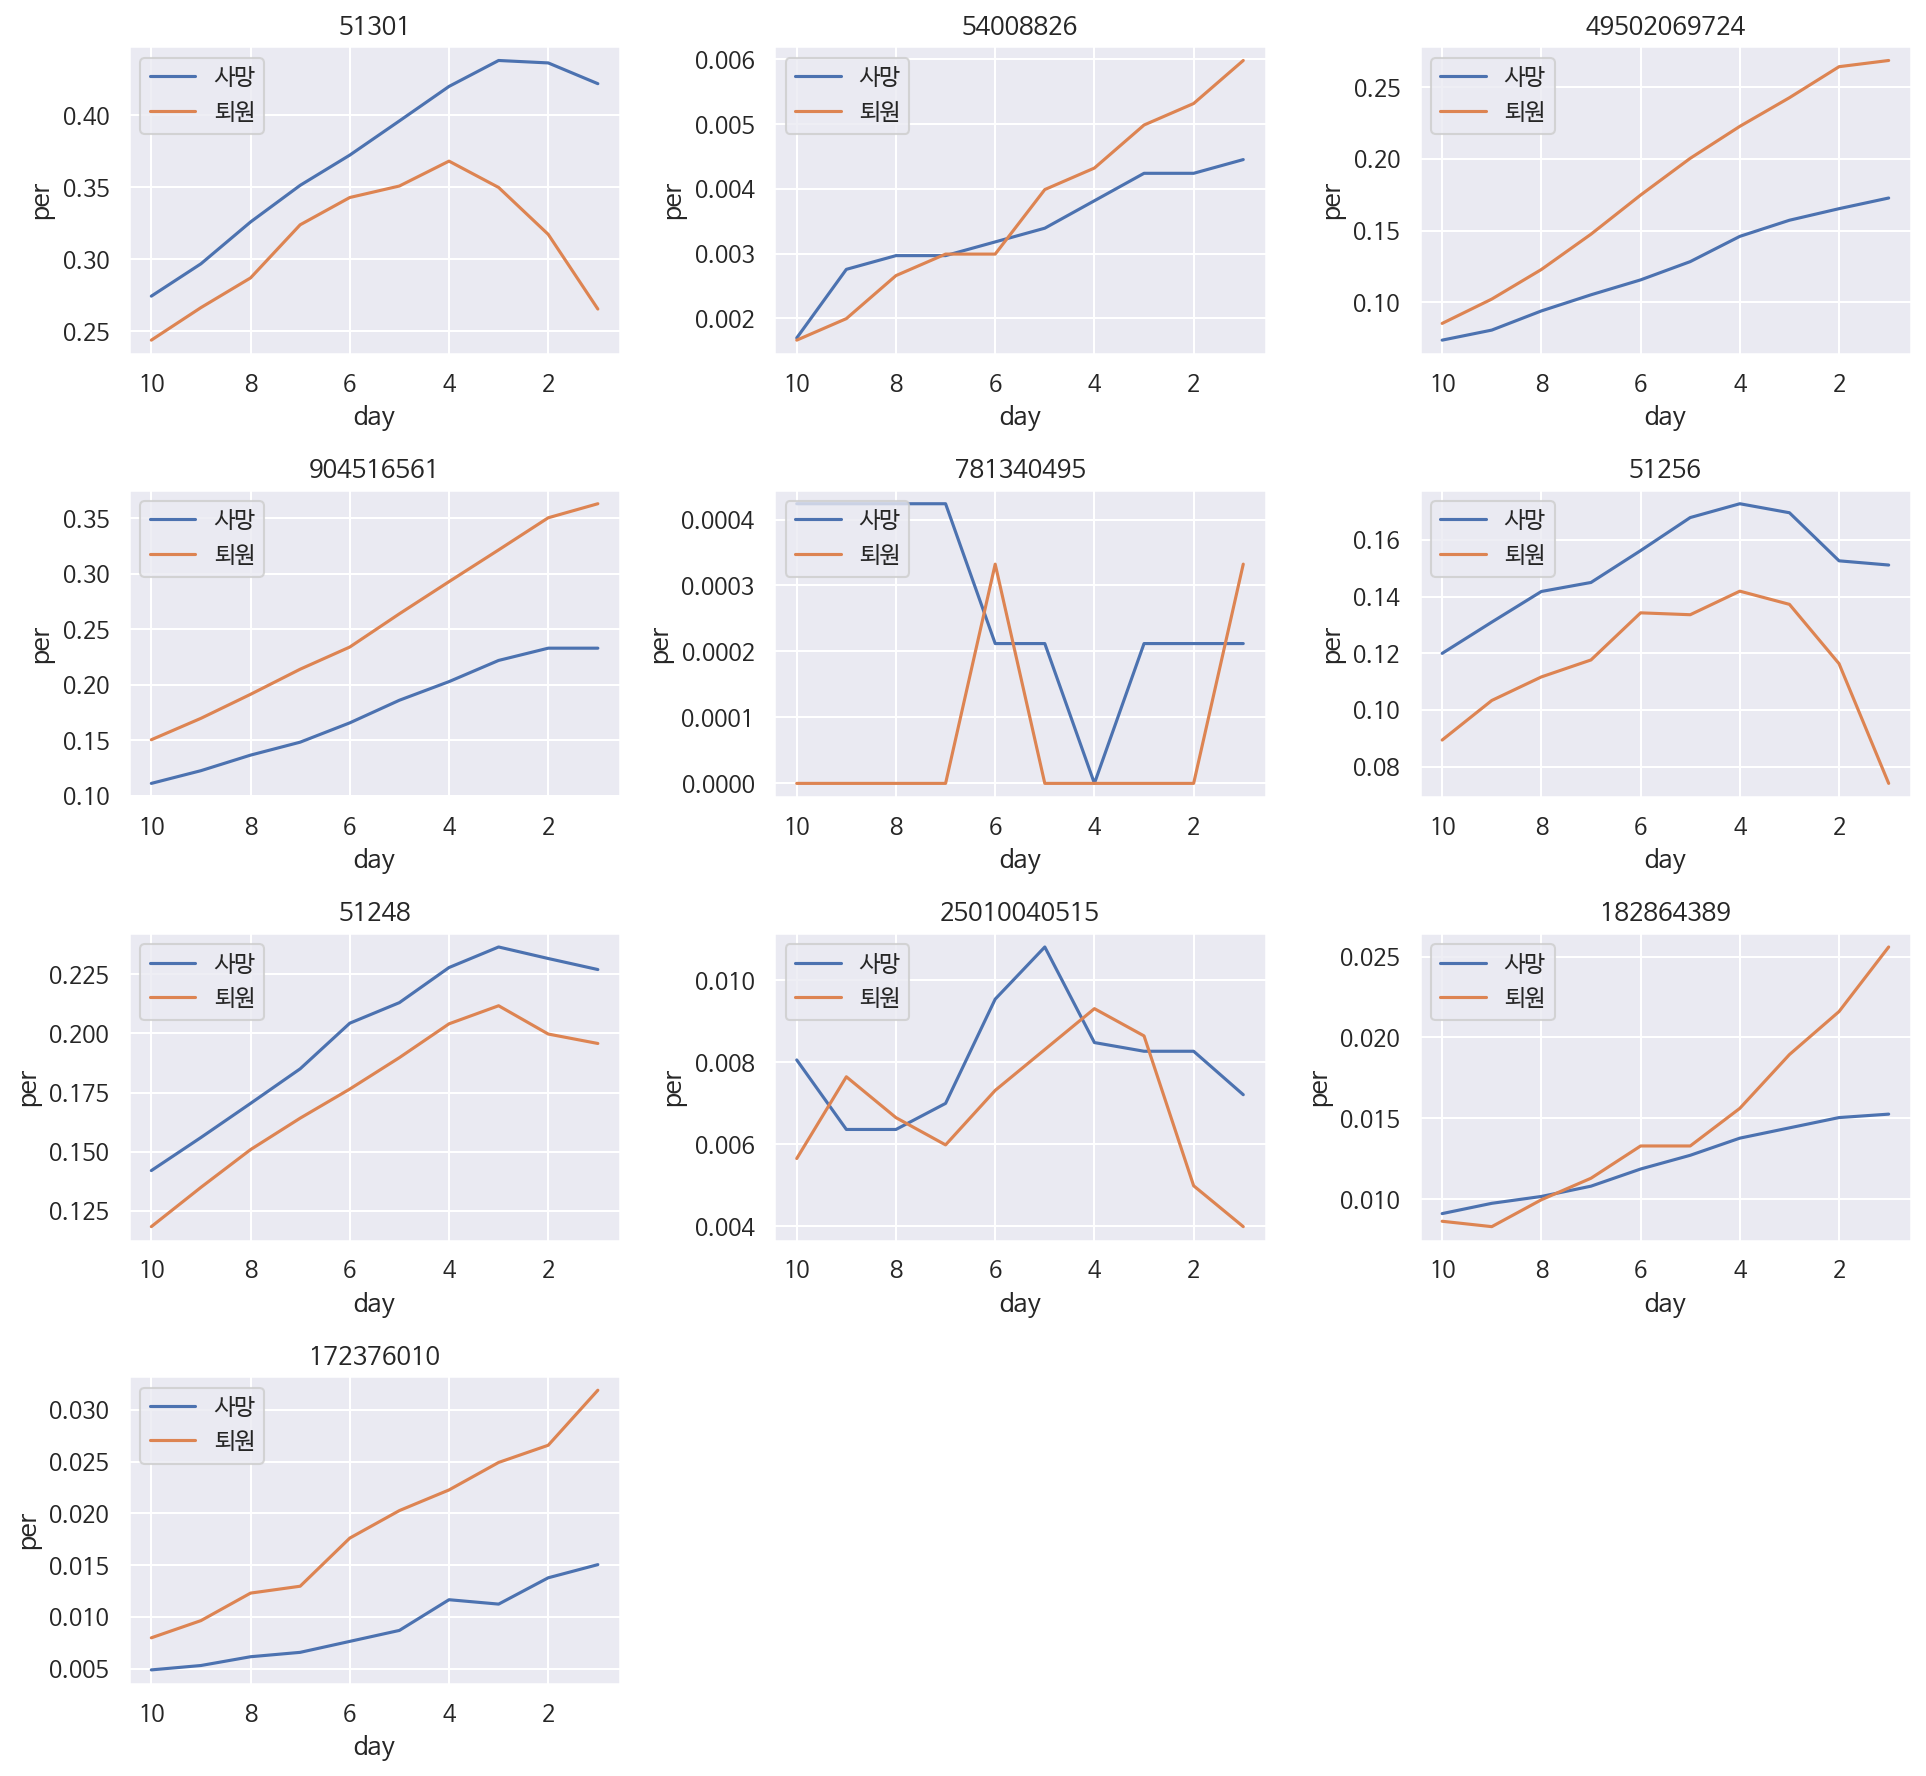

In [92]:
visualization(temp[temp['Type']=='PRE'].feature[:10])

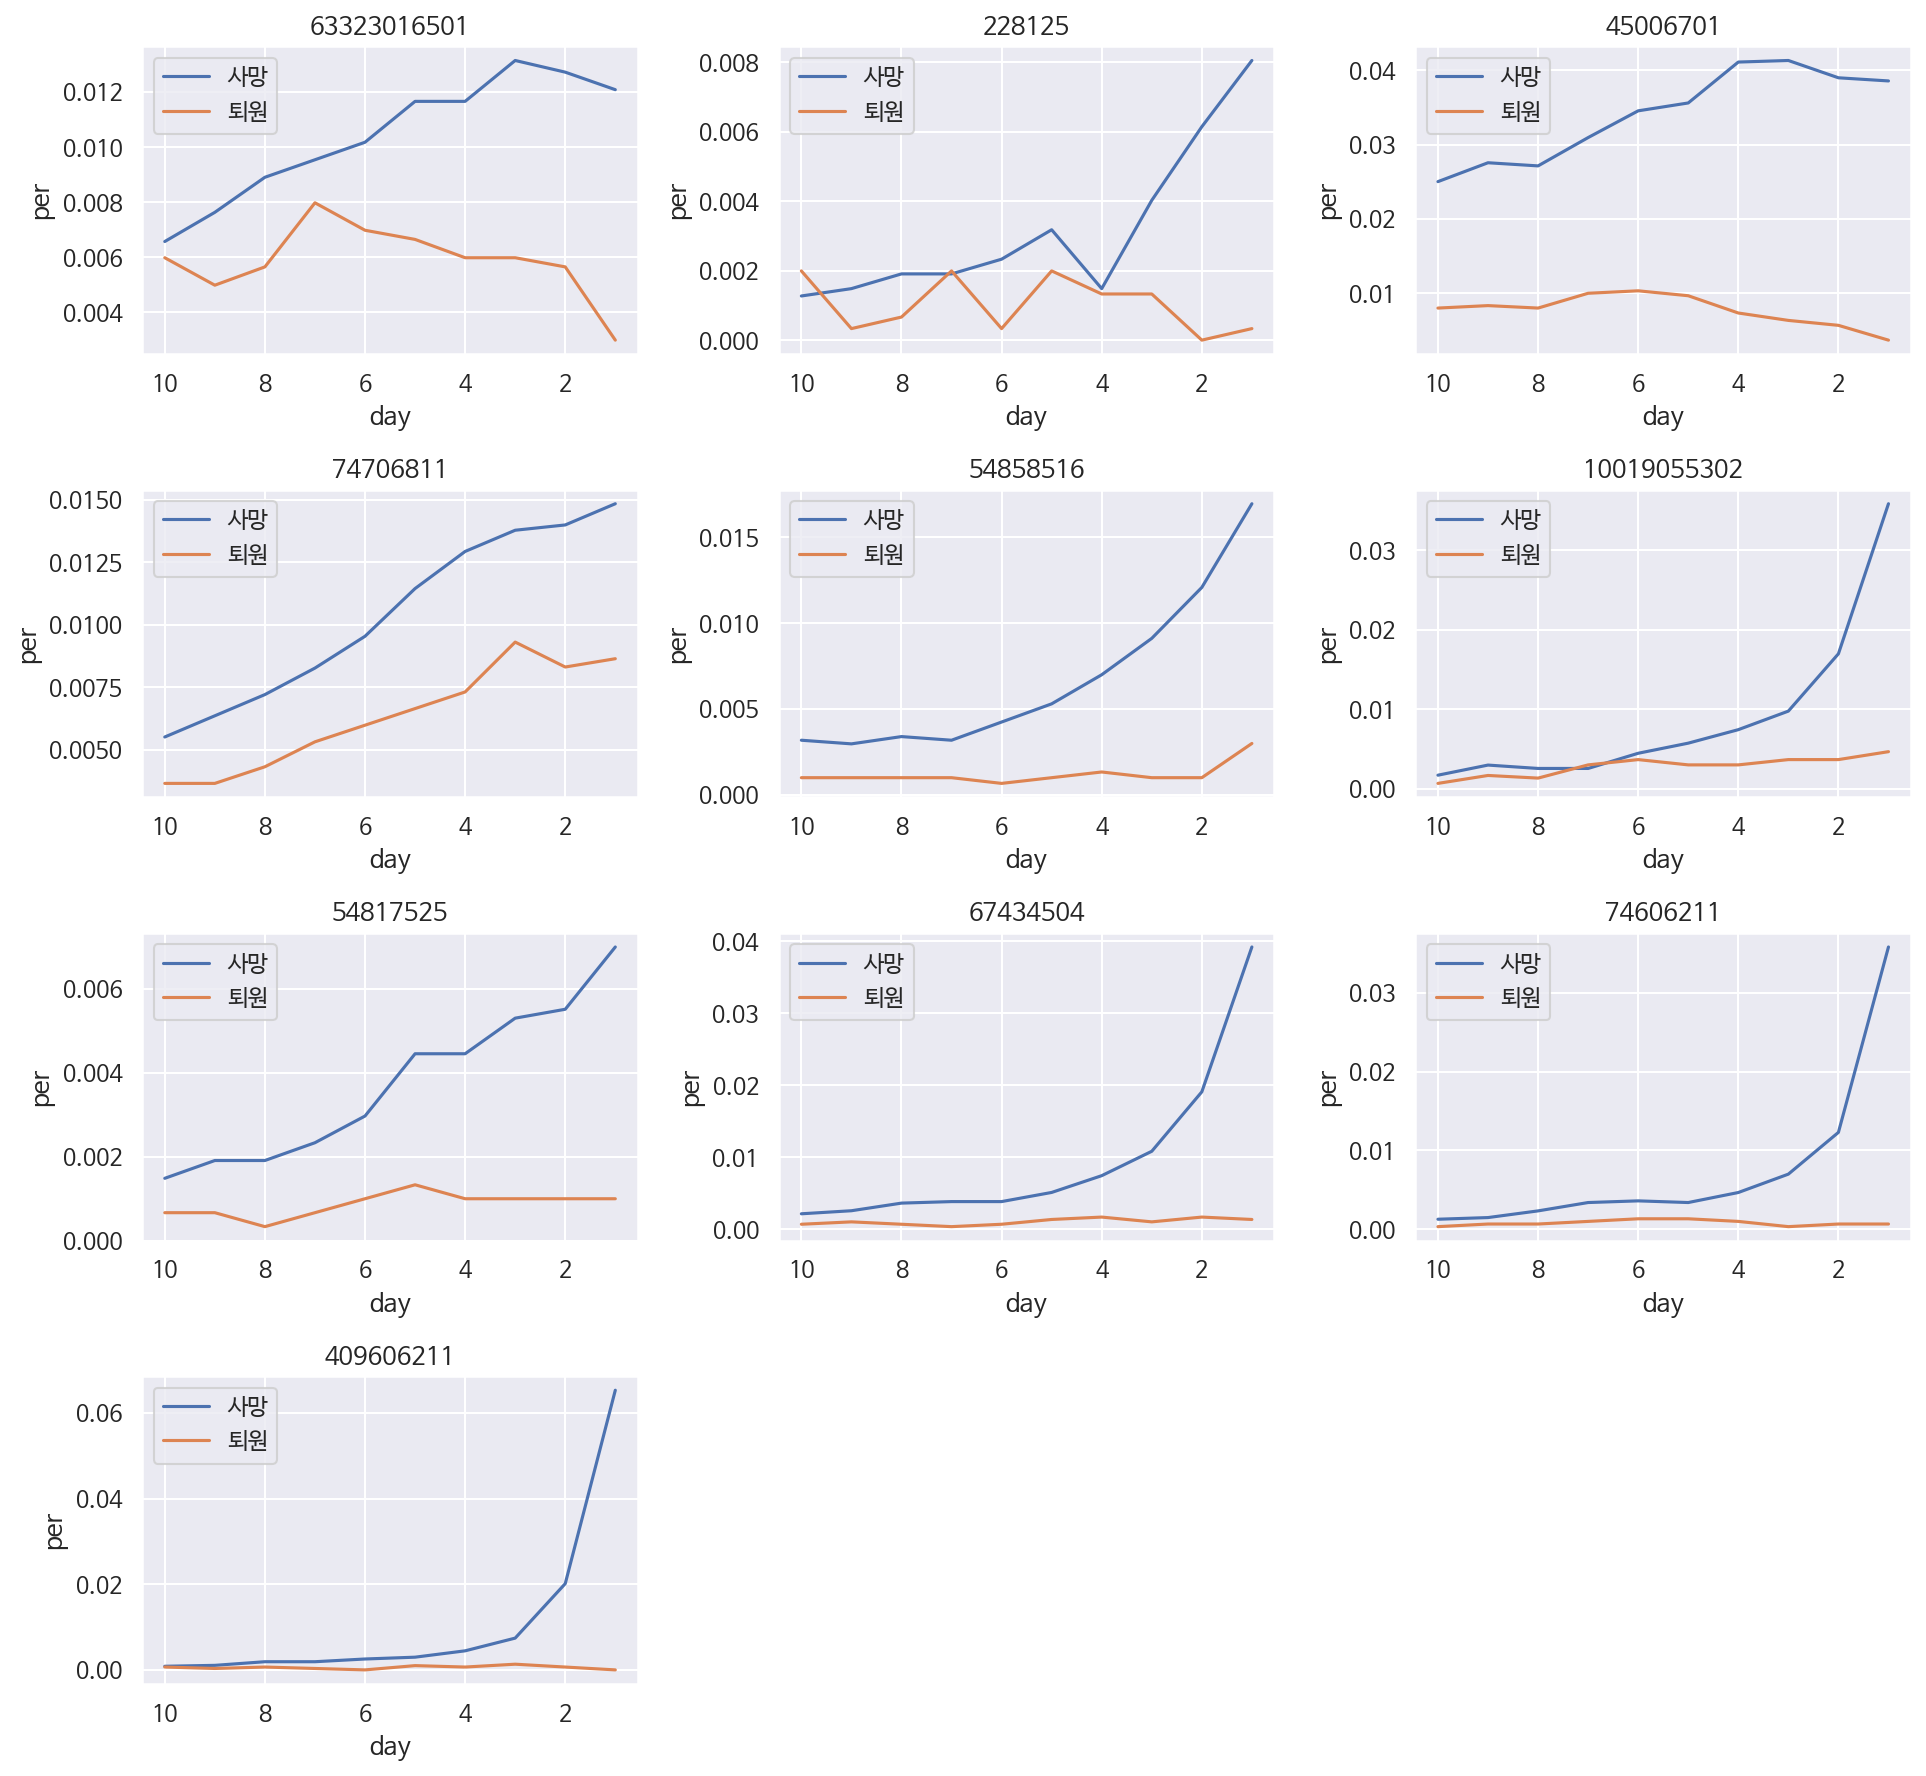

In [97]:
visualization(temp[temp['Type']=='PRE'].feature[-10:])

## Score1 기준 (std만 나눠줌)

In [107]:
temp1 = final_df.copy()
temp1 = temp1.sort_values('score1', ascending=False)
temp1.feature[:10], temp1.feature[-10:]

(217           51301
 2945    49502069724
 2571      781340495
 933        54008826
 2633      904516561
 2859    25010040515
 3895    63653133202
 934        54009720
 1830      182864389
 186           51248
 Name: feature, dtype: int64,
 3820    63323016501
 392          228125
 845        45006701
 1306       74706811
 1011       54858516
 2744    10019055302
 982        54817525
 1081       67434504
 1276       74606211
 2195      409606211
 Name: feature, dtype: int64)

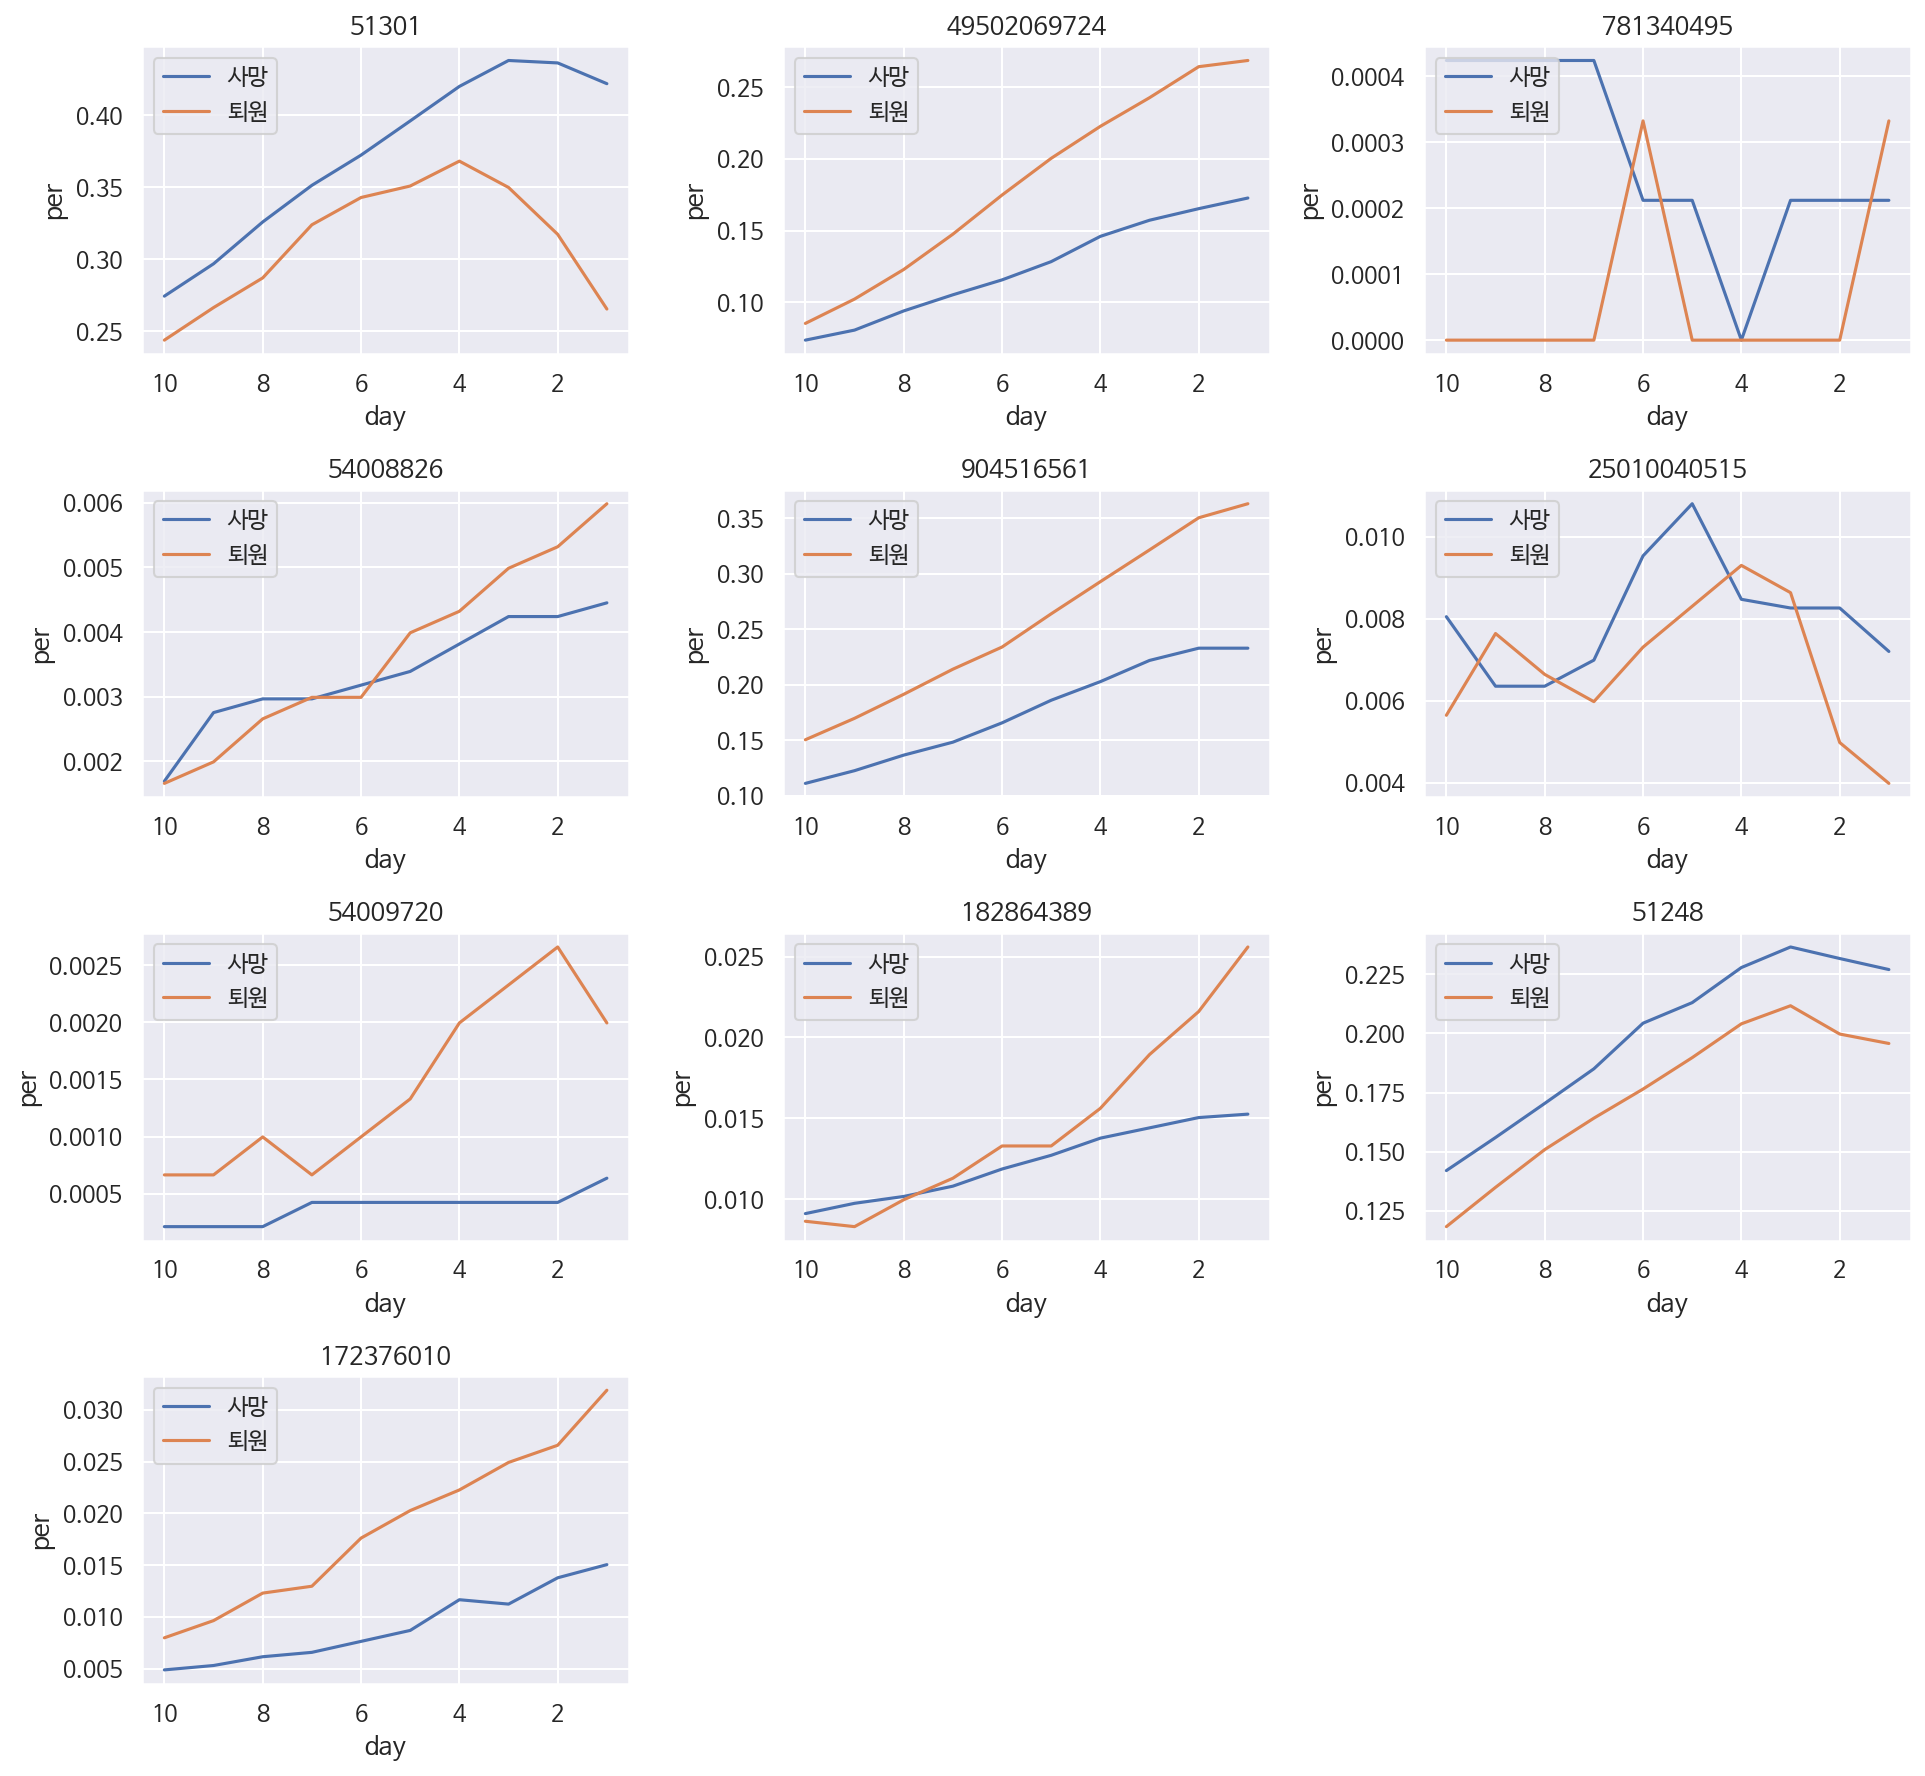

In [99]:
visualization(temp1[temp1['Type']=='PRE'].feature[:10])

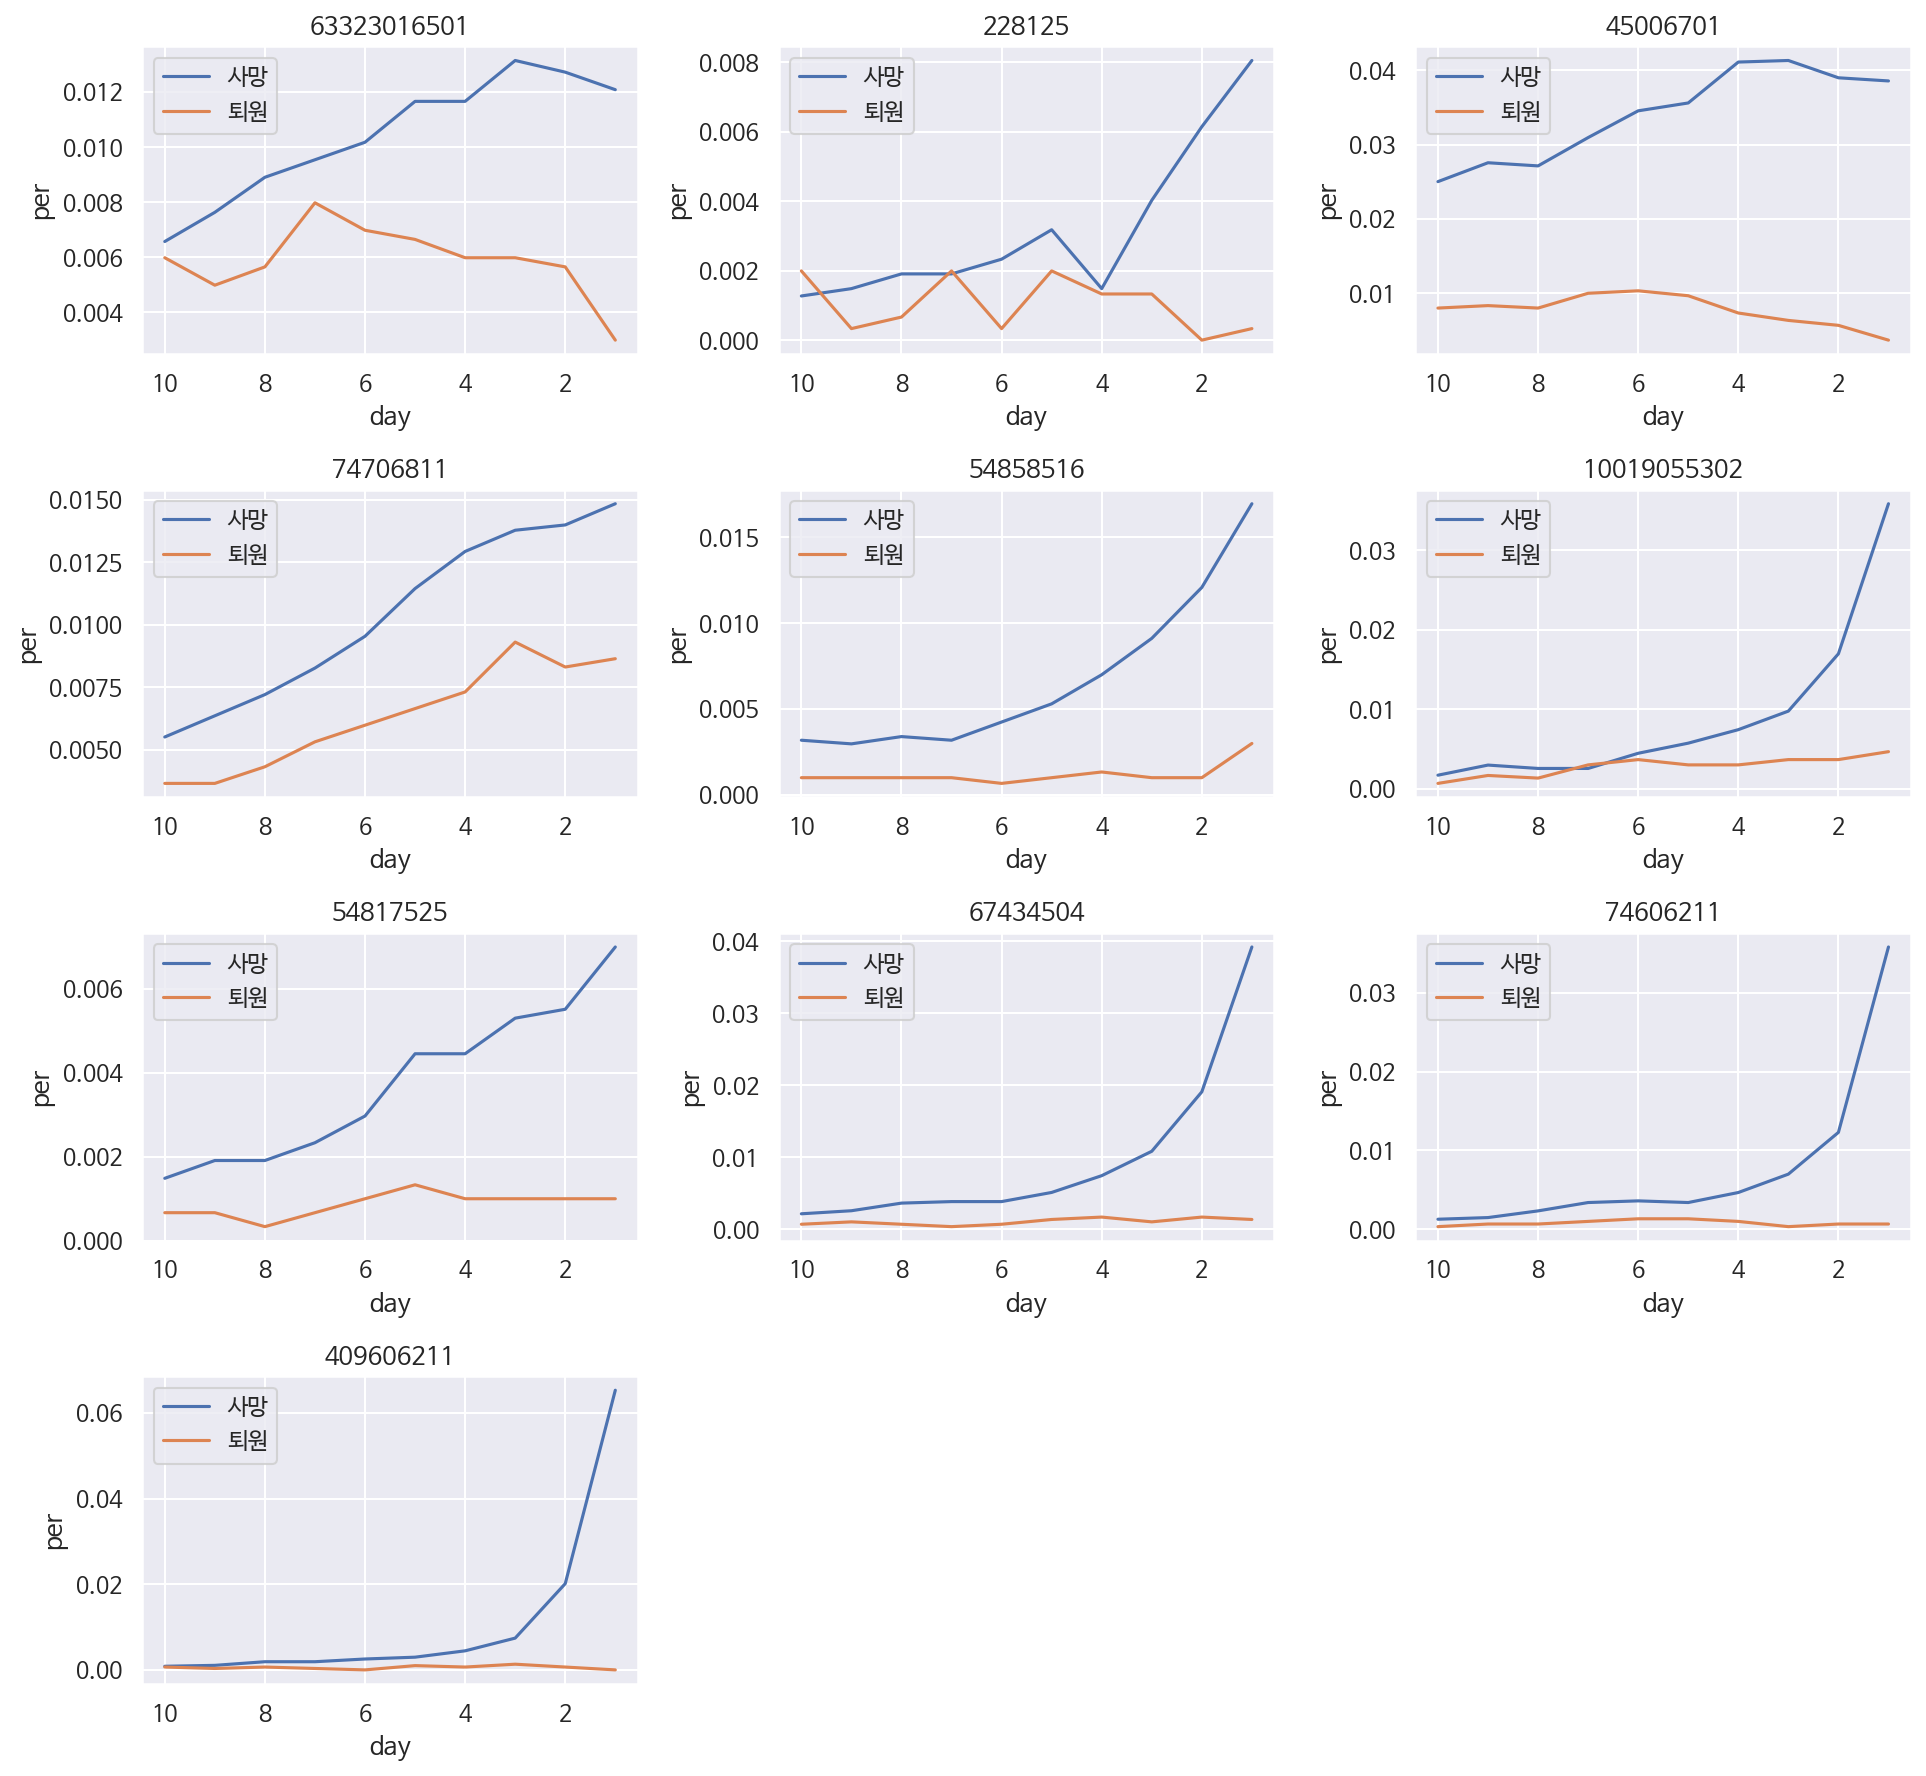

In [102]:
visualization(temp1[temp1['Type']=='PRE'].feature[-10:])

##  표준화

In [104]:
temp2 = final_df.copy()
temp2 = temp2.sort_values('score2', ascending=False)

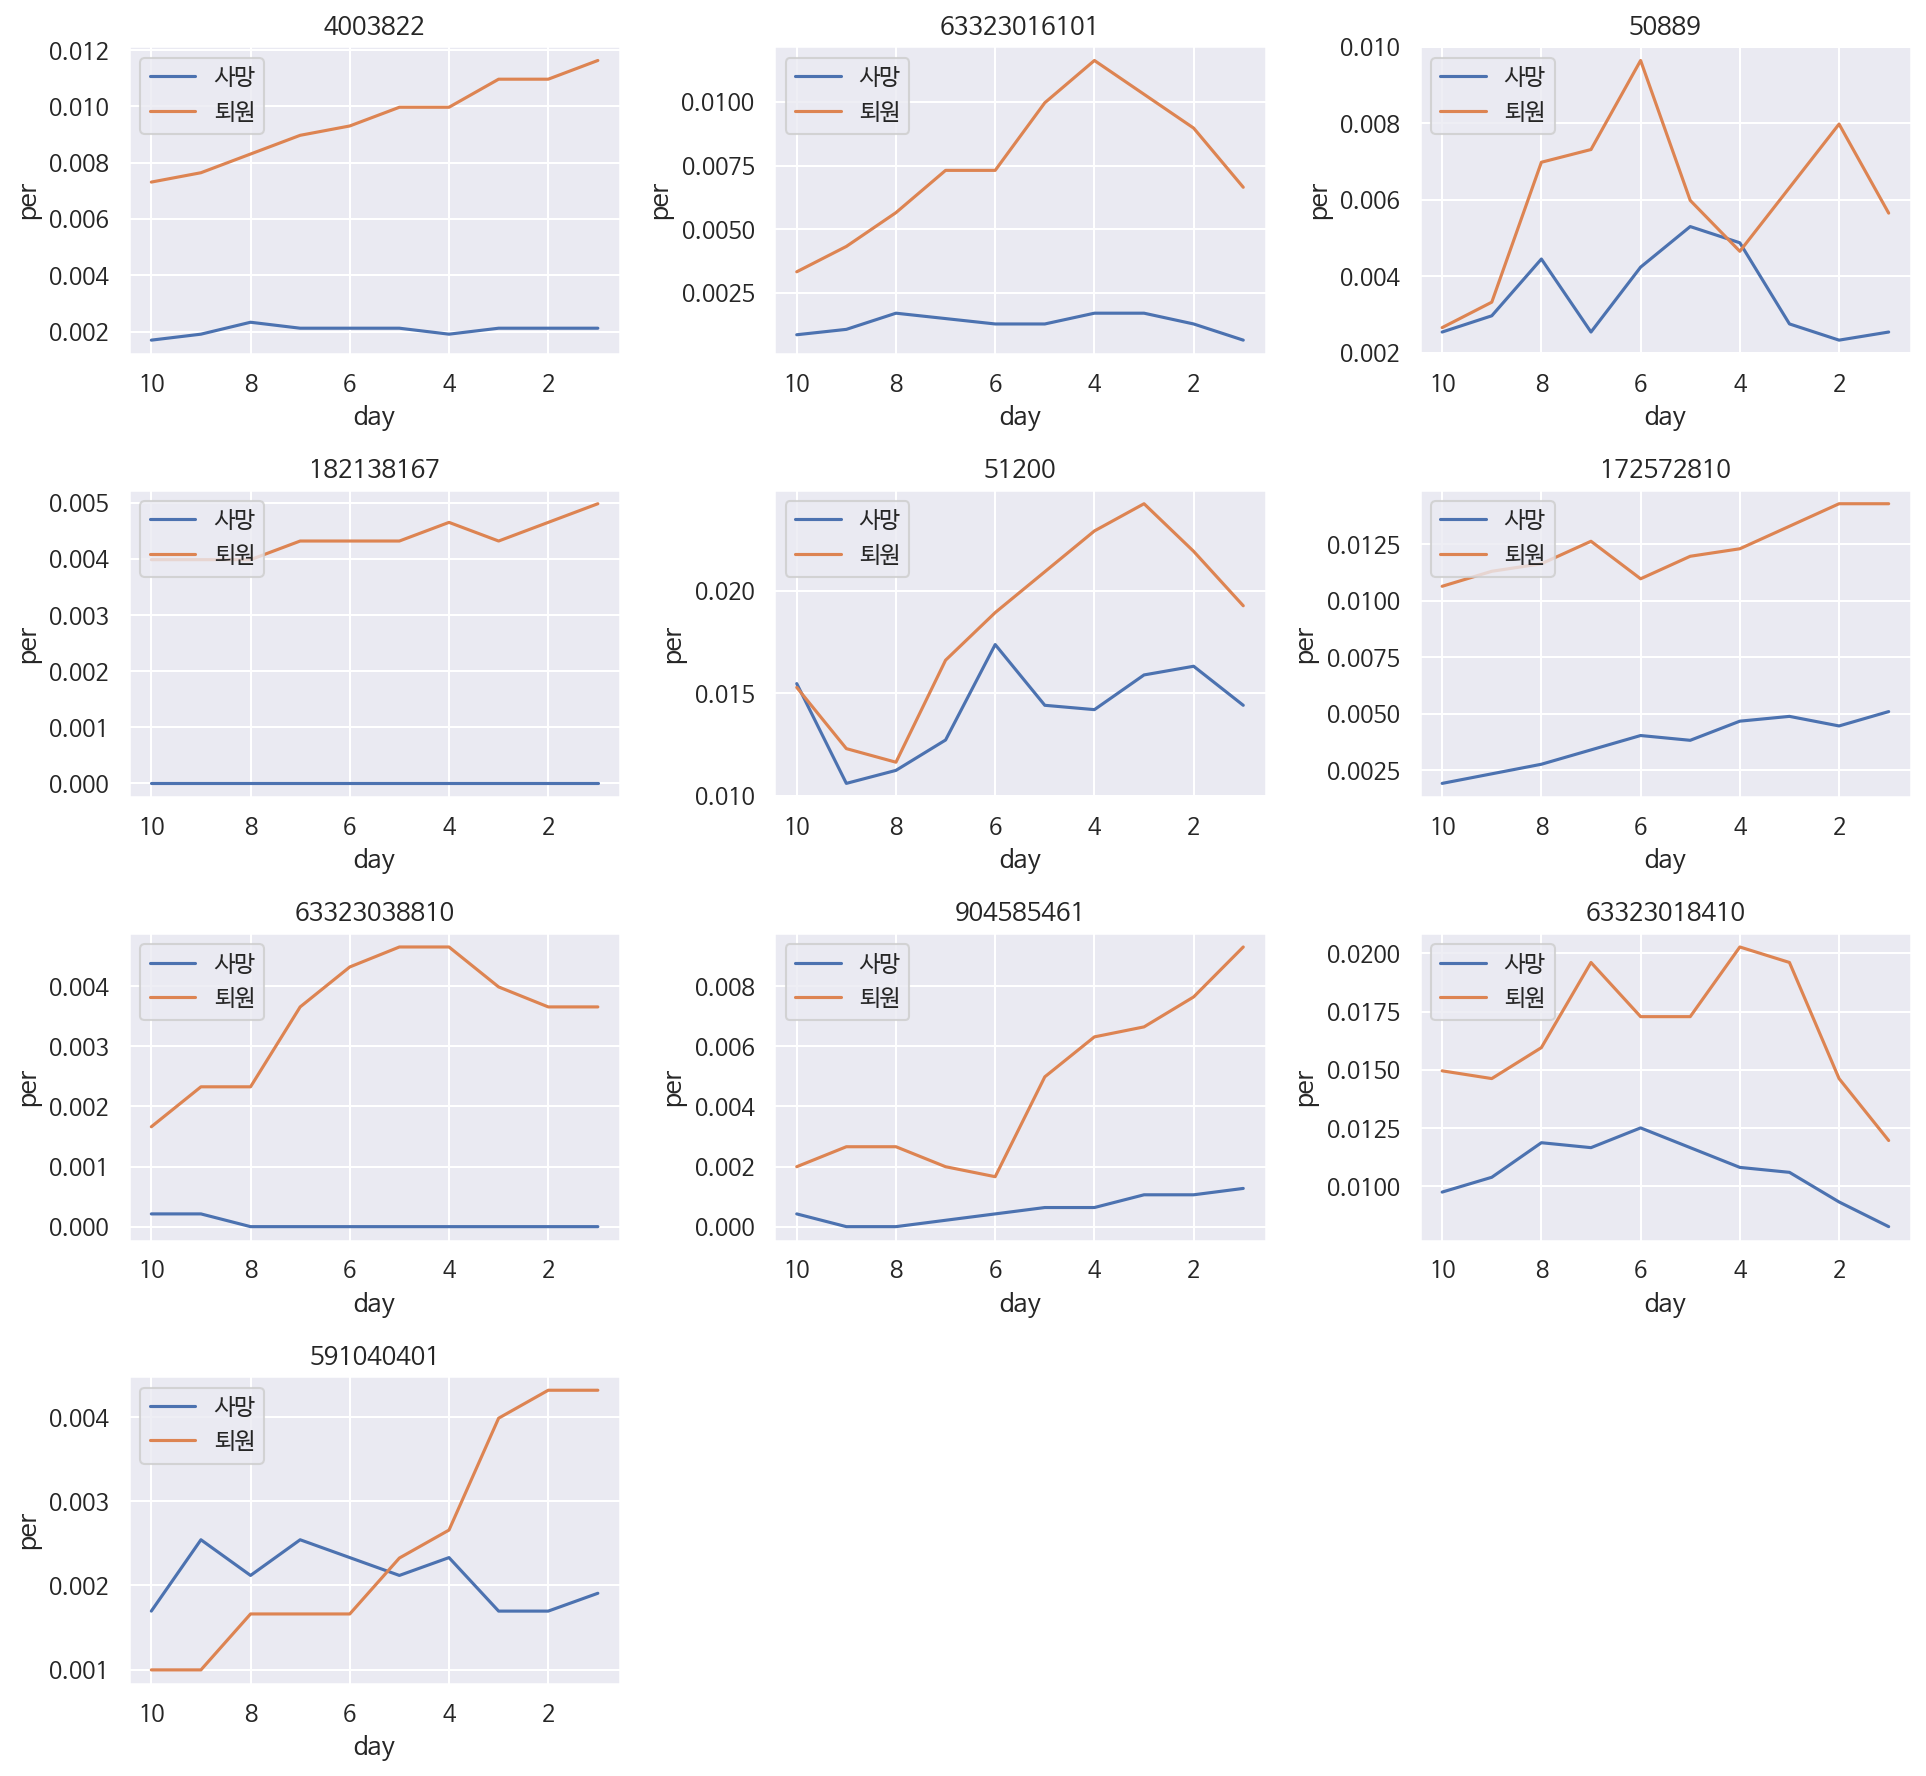

In [105]:
visualization(temp2[temp2['Type']=='PRE'].feature[:10])

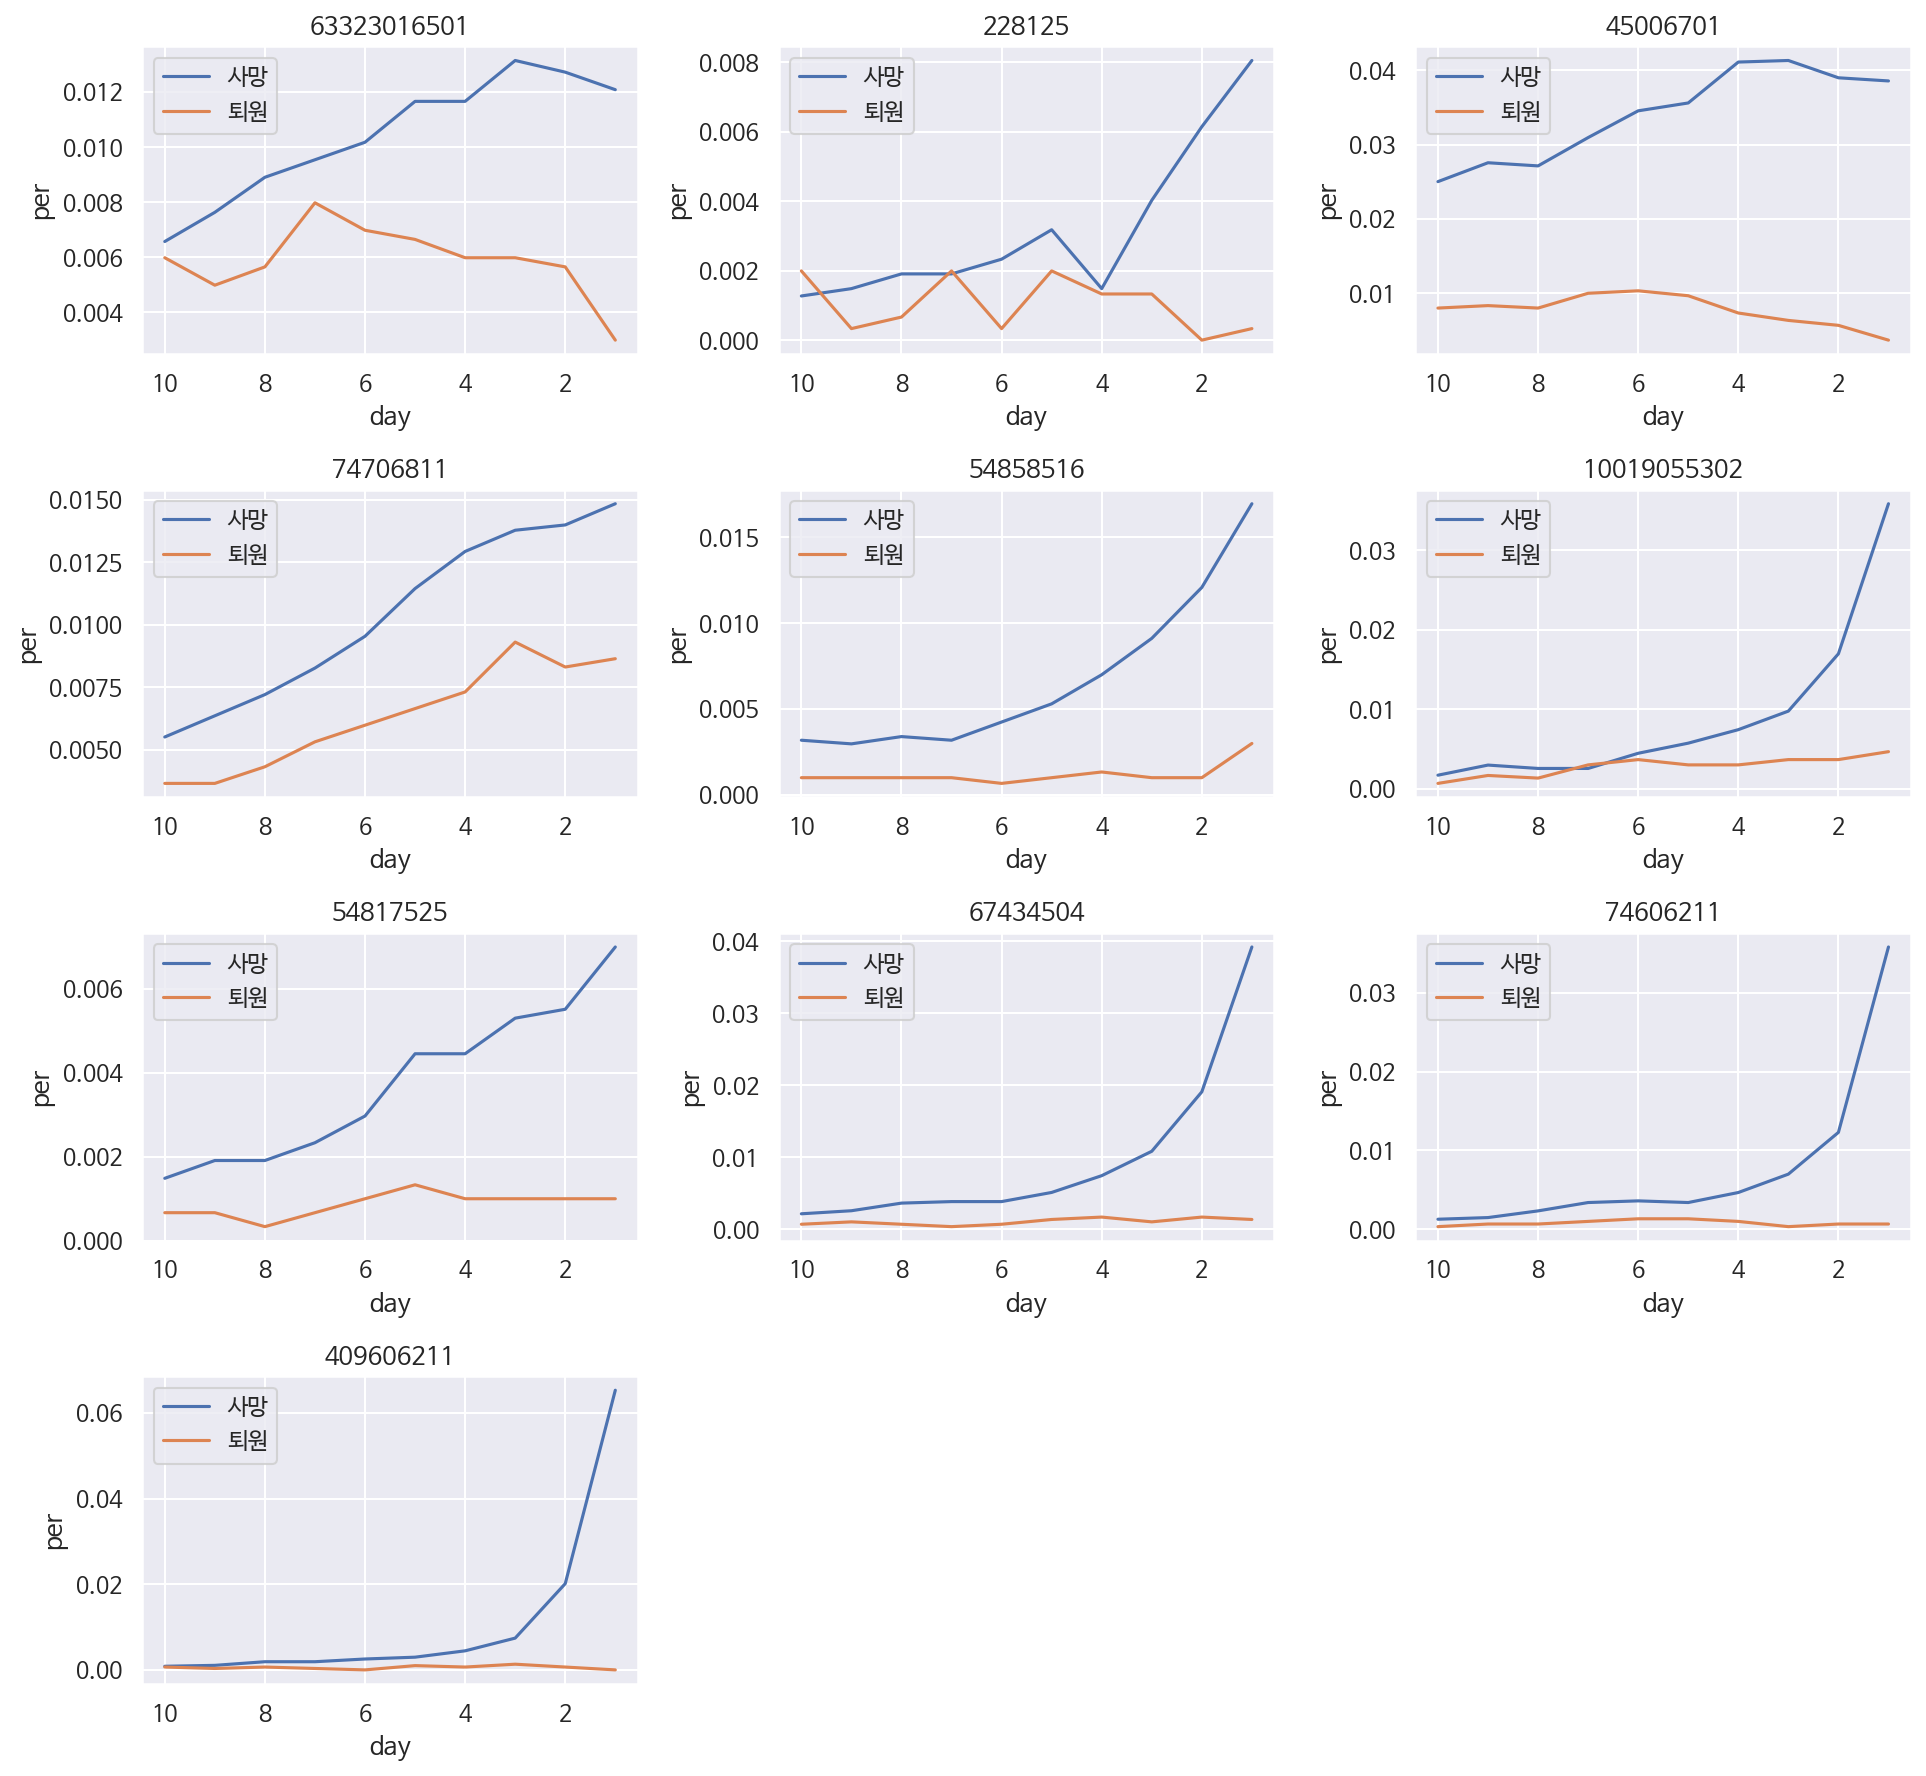

In [106]:
visualization(temp2[temp2['Type']=='PRE'].feature[-10:])

# Feature 확인

In [111]:
original = pd.read_csv('./data/method2_finalscore.csv')
pro_list = original[original['Type']=='PRO'].feature[:10]
pre_list = original[original['Type']=='PRE'].feature[:10]
lab_list = original[original['Type']=='LAB'].feature[:10]

In [118]:
original.feature[:10].to_list()

[227194,
 4003822,
 63323016101,
 50889,
 25021011210,
 182138167,
 51200,
 172572810,
 63323038810,
 904585461]

In [122]:
temp1.feature[:10].to_list()

[51301,
 49502069724,
 781340495,
 54008826,
 904516561,
 25010040515,
 63653133202,
 54009720,
 182864389,
 51248]